# MA934 Numerical Methods - Workbook 3

If you haven't already done so, install the DualNumbers Julia package. It is a good idea to update all your packages first. The commands are

```
Pkg.update()
Pkg.add("DualNumbers")
```

but you only need to run them once. 

In [1]:
# Pkg.update()
#Pkg.add("DualNumbers")
using Plots
font1 = Plots.font("Helvetica", 12)
pyplot(guidefont=font1, xtickfont=font1, ytickfont=font1, legendfont=font1)
using DualNumbers
include("MODULES/MyUtils_wb3.jl")

golden_section (generic function with 1 method)

## Question 1: Numerical differentiation

**1))** Derive a finite difference formula for the derivative of a function, $f$ at a point $x$ using the 3-point stencil $(x, x+h, x+2h)$ and state the order of the approximation error in terms of $h$.

**2)** Write a formula for the derivative, $f^\prime(x)$, of the function

$$f(x) = \sin(\exp(x)) $$

and evaluate it at $x=1$.

**3)** Use your finite difference formula to approximate the value of $f^\prime(1)$ for values of $h$ decreasing from $2^{-1}$ to $2^{-30}$ in powers of $2$. Plot the error as a function of $h$ and verify the theoretically predicted scaling of the error with $h$. What is the best relative error you can achieve?

**4)** Read the examples at https://github.com/JuliaDiff/DualNumbers.jl. Define a dual number $x = 1+\epsilon$ and use it to evaluate $f^\prime(1)$. Verify that the answer is accurate to within machine precision.

1) 

We evaluate the function f(x) at the points of the stencil and taylor expand the function around these points:

\begin{align}
f(x)&=f(x)\\
f(x+h)&=f(x)+f'(x)h+f''(x)\frac{h^2}{2}+\mathcal{O}(h^3)\\
f(x+2h)&=f(x)+2f'(x)h+2f''(x){h^2}+\mathcal{O}(h^3)
\end{align}

We define F as a linear combination of the stencil: 

 $$F= A f(x) + B f(x+h) + C f(x+2h)$$


We want to use $F$ to approximate $f'(x)$, so we have to solve the following system of linear equations: 

\begin{align}
A+B+C&=0\\
B+2C&=1\\
\frac{B}{2}+2C&=0
\end{align}

Solving this gives $ A=-3/2 , B=2 , C=-1/2$

With this choice of $A,B,C$ we have $F=f'(x)h+\mathcal{O}(h^3)$. Rearranging this suggests that 

$$ f'(x) = \frac{-3f(x)+4f(x+h)-f(x+2h)}{2h}+\mathcal{O}(h^2)$$

Therefore the order of the approximation error is $h^2$.


2) 
We want to evaluate the derivative of $f(x)=\sin(\exp(x))$ at $x=1$. 

$$ f'(x)=\cos(\exp(x))\exp(x)$$

For $x=1$ we therefore get 

$$ f'(1)=\cos(e)e$$

3)

We evaluate the finite differnece formula from part 1 for $h$ from $2^{-1}$ to $2^{-30}$ in powers of 2. We plot the error as a function of $h$. 


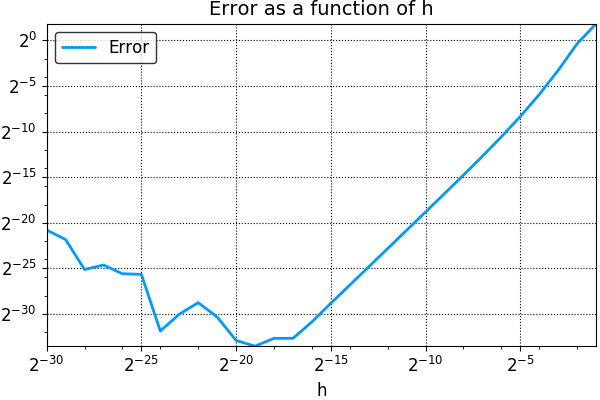

/home/annika/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [2]:
der=cos(exp(1))*exp(1)

h=zeros(30)
z=zeros(30)

for i=1:30
    h[i]=2.0^(-i)
    z[i]=abs(f_prime_num(h[i])-der)
end

plot(h,z,linewidth=2, yscale=:log2, xscale=:log2,xlabel="h", label="Error",title="Error as a function of h")


Initially we find that the error is decreasing with h, as expected, but as h gets too small (less than $\approx 2^{-17}$) the floating point arithmetics cause a significant rounding error. In the decreasing region, we see that the plot is approximately linear (on a log/log scale). Therefore we expect the error to go as a power law (error $\sim h^k$) where $k$ is the gradient of the straight line. To find this gradient we only consider h from $2^{-1}$ to $2^{-17}$ and use the function "lingreg" to fit a line (linear regression). We find that gradient of the line is 2.13 , which roughly matches our expectations from part 1 (i.e. error $\mathcal{O}(h^2)$). 

The best relative error (minimum error) we can achieve is the minimum of the error function displayed above which equals $2^{-33.5}$.

In [3]:
println(log2(findmin(z)[1]))

-33.53770543011393


The gradient of the best fit line is
2.133171415592277



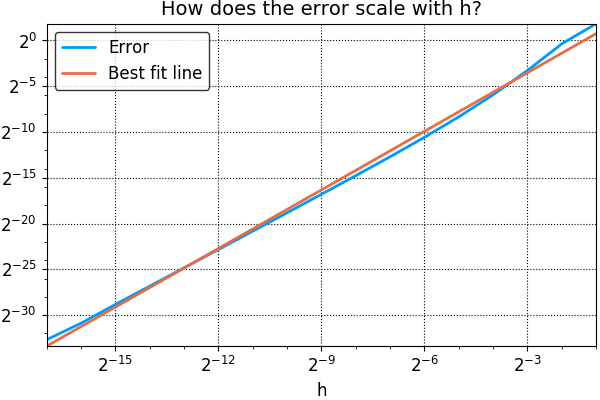

In [4]:
h_cut=h[1:17]
z_cut=z[1:17]
h_cut_log=log2(h_cut)
z_cut_log=log2(z_cut)

a,b=linreg(h_cut_log,z_cut_log)
println("The gradient of the best fit line is")
println(b)

plot(h_cut,z_cut,linewidth=2,label="Error",xlabel="h",title="How does the error scale with h?",yscale=:log2,xscale=:log2)
plot!(h_cut,2.^(b*h_cut_log+a),linewidth=2,label="Best fit line")

## Question 2: Finding roots

**1)** Referring to the function, $f(x)$, defined above, find the roots of the equation

$$ f(x) = 0$$

in the interval $0<x<2$.

**2)** Implement the bracketing and bisection method to find one of the roots numerically. Measure the error at each iteration of the algorithm and demonstrate that the error decreases exponentially as a function of the number of iterations. To how many digits of precision can you approximate the root?

**3)** Perform the same measurements for the Newton Raphson method and show that the error decreases faster than exponentially as a function of the number of iterations.

1)
We want to find the roots of the function $$f(x)=\sin(\exp(x))$$ 

For $f(x)$ to be $0$, $\exp(x)$ has to be equal to $k\pi$ for integer $k$. Solving $\exp(x)=k\pi$ we get $x=\log(k\pi)$. As we're only interested in solutions for $x \in [0,2]$, we solve $\log(y)=0$ and $\log(y)=2$ which gives us $k\pi \in [1, exp(2)\sim 7.4]$. Therefore our roots are $\log(\pi)$ and $\log(2\pi)$.

2) 
We want to find numerically find the root $\log(\pi)$ of the function $f(x)$ using the Bracketing and Bisection method. 


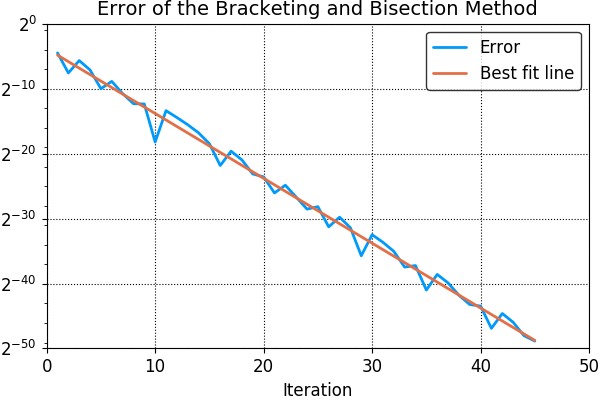

In [5]:
maxstep=45
a=1.0
b=1.2
steps,estimates=bracket_and_bisect(a,b,f,maxstep)

ana=log(pi)
errors=abs(estimates-ana)


error_log=log2(errors)
a,b=linreg(steps,error_log)
plot(steps,errors,linewidth=2,xlabel="Iteration",title="Error of the Bracketing and Bisection Method",label="Error",yscale=:log2)
plot!(steps,2.^(b*steps+a),linewidth=2,label="Best fit line")

As $\log(\pi)$ is approximately $1.145$ we choose our inital interval to be $[a,b]=[1.0,1.2]$. We iterate the algorithm 45 times. The number of iterations is set to 45 as a bigger number of iterations (e.g. 50) turned out not be sensible due to the floating point arithmetics. We plot the calculated error against the iteration number on a log-linear scale. The plot is approximately linear (see bestfit line) which implies that the error decreases exponentially with the iteration number. 

In [8]:
println(estimates[45])
println(log(pi))

1.1447298858493982
1.1447298858494002


Our best estimate of the root is 1.1447298858493982. The first 12 decimal places equal the ones of the analytical root $\log(\pi)$.

3)

We now want to find the roots of the function using the Newton Raphson method. To do that, we use the analytics
derivative that we found in Q1 part 2: 

$$f'(x)=\cos(\exp(x))\exp(x)$$.

In [9]:
maxstep=10
x0=1.0
steps,estimates=newton_raphson(x0,f,f_prime_ana,maxstep)

errors=abs(log(pi)-estimates)

println("The error values for the first 10 steps are")
println(errors)

The error values for the first 10 steps are
[0.021018,0.000188414,1.77268e-8,2.22045e-16,0.0,0.0,0.0,0.0,0.0,0.0]



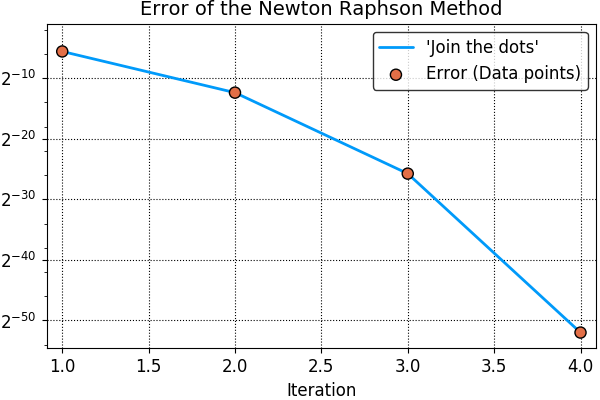

In [10]:
error_log=log2(errors[1:4])
plot(steps[1:4],errors[1:4],linewidth=2,label="'Join the dots'",xlabel="Iteration",title="Error of the Newton Raphson Method",yscale=:log2)
scatter!(steps[1:4],errors[1:4],markersize=8,label="Error (Data points)",ylims=(2.0^(-55),2.0^(-1)))

We want to find the root at $\log(\pi)$ so we choose an inital value of $x_0=1.0$. The Newton Raphon algorithm finds the root extremely fast. Printing the error value for the first ten steps (see above), we see that the error is "equal" to zero after step 4.  We therefore only plot the first four datapoints. Plotting error against iteration on a log-linear plot we see that the curve decays faster than a linear function implying a superexponential error decay. 

## Question 3: Finding minima

**1)** The function $f(x)$ above has a single minimum in the interval $0<x<2$. Find its location analytically.

**2)** Implement the Golden section search to find the location of this minimum numerically. Plot the error as a function of the number of iterations. To how many digits of precision can you approximate the location of the minimum?

**3)** To understand your empirical findings, use Taylor's Theorem to show that near a minimum, $x_*$, of f(x),

$$f(x) \approx f(x_*)\left( 1+ \frac{f^{\prime\prime}(x_*)}{2\,f(x_*)}\,(x-x_*)^2\right). $$
Show that in order for a computer to distinguish between $f(x)$ and $f(x_*)$ we must have

$$ \left| x-x_*\right| > \sqrt{\epsilon_m}\,\sqrt{\left|\frac{2\,f(x_*)}{f^{\prime\prime}(x_*)}\right|}$$

thus limiting the precision with which the location of a minimum can be determined.

1)

We wish to find the extrema of $f(x)$ so set

$$f'(x)=\cos(\exp(x))\exp(x)=0$$

So $\exp(x)=(n+\frac{1}{2})\pi$ for integer $n$ or equivalently $x=\log((n+\frac{1}{2})\pi)$. In the interval $x\in [0,2]$ there are just two extrema:

$$
x=\log(\frac{\pi}{2})\qquad x=\log(\frac{3\pi}{2})
$$

As the function $\sin(x)$ is oscillatory and $\exp(x)$ is monotonic increasing we know that the extrema of $f(x)$ will oscillate between ...-maximum-minimum-maximum-minimum...

At $x=0$ the value of $\exp(x)$ is $1<\frac{\pi}{2}$ (the first maximum of $\sin(x)$) therefore the first extremum at $x=\log(\frac{\pi}{2})$ is a maxima and the the extremum at $x=\log(\frac{3\pi}{2})$ is the minimum required.

2) 

We implement the Golden section search to find the minimum $\log(\frac{3\pi}{2})$ numerically. 


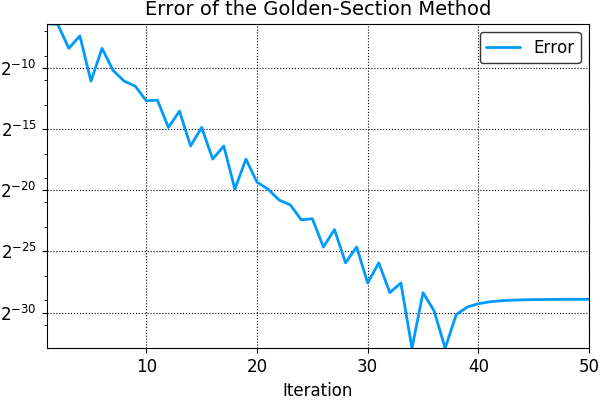

In [11]:
maxstep=50
a=1.4
c=1.6

steps,estimates=golden_section(a,c,f,maxstep)

ana=log(3*pi/2)
error=abs(estimates-ana)
plot(steps, error,linewidth=2,label="Error",yscale=:log2,xlabel="Iteration",title="Error of the Golden-Section Method")

Until float point operations cause rounding errors (say beyond iteration 35) the plot on a log-linear scale looks linear. This implies we have (for error $\epsilon$ and iteration $i$):

$$
\epsilon \sim 2^{-\alpha i}
$$

Lets find $\alpha$ by fiting a line:


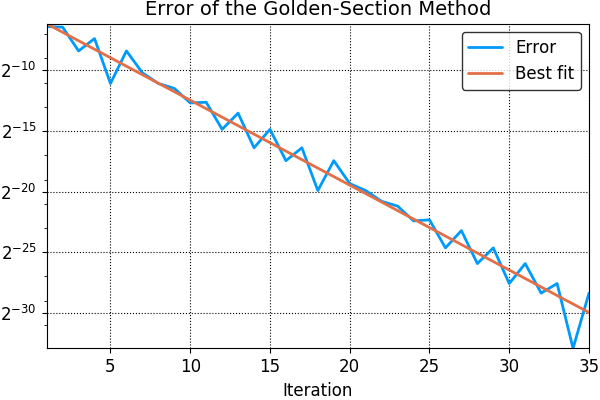

In [12]:
log_error=log2(error[1:35])
a,b=linreg(steps[1:35],log_error)

plot(steps[1:35],error[1:35],linewidth=2,label="Error")
plot!(steps[1:35],2.^(b*steps[1:35]+a),linewidth=2,label="Best fit",yscale=:log2,xlabel="Iteration",title="Error of the Golden-Section Method")

The gradient on a log-linear (base 2) plot is 

In [13]:
println(b)

-0.7006920586740238


Equivalently we may write 

$$
\epsilon \sim \phi^{-i}
$$

where $\phi := 2^\alpha$. We find that $\phi$ is:

In [14]:
2^abs(b)

1.6252842521929587

This is approximately equal to the value of the golden ratio:

In [15]:
0.5*(1+sqrt(5))

1.618033988749895